# First attempt at the LSM Simulator below

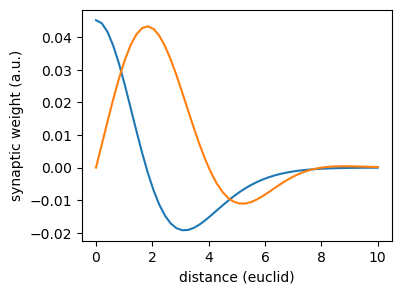

In [7]:
gaussian = lambda x, sigma: (unnorm:=np.exp(-x**2/sigma**2))/unnorm.sum()
def mexican_hat_kernel(
    distance: float,
    sigma_exc: float = 2.,
    sigma_inh: float = 3.5,
    scale_exc: float = 1.,
    scale_inh: float = 1.    
) -> float:
    return scale_exc*gaussian(distance, sigma_exc) - scale_inh*gaussian(distance, sigma_inh)

def wave_kernel(
    distance: float,
    wavelength: float=8.,
    scale: float = 1.,
    upper_bound_peak = 1.
)-> float:
    scaling = wavelength / (2*np.pi)
    upper_bound = gaussian(distance-upper_bound_peak, 3*scaling)
    return scale* np.sin(distance/scaling)*upper_bound


x = np.linspace(-0,10)
plt.figure(figsize=(4,3))
plt.plot(x, mexican_hat_kernel(x));
plt.plot(x, wave_kernel(x, upper_bound_peak=1));
plt.xlabel("distance (euclid)");
plt.ylabel("synaptic weight (a.u.)");

In [8]:
def compute_distance_matrix(
    neuron_pos: np.ndarray
) -> np.ndarray:
    n_neurons = neuron_pos.shape[0]
    distance_matrix = np.empty((n_neurons,n_neurons))
    for i in range(n_neurons):
        for j in range(n_neurons):
            distance_matrix[i,j] = np.sqrt(((neuron_pos[i,:] - neuron_pos[j,:])**2).sum())
    return distance_matrix

plt.hist(compute_distance_matrix(neuron_pos).ravel(), bins=20);

NameError: name 'neuron_pos' is not defined

In [ ]:
def create_weights_matrix(
    neuron_pos: np.ndarray,
    weights_kernel: Callable,
    debug: bool=False,
    **weights_kernel_kwargs
) -> np.ndarray:
    distance_matrix = compute_distance_matrix(neuron_pos)
    if debug:
        print(f"{distance_matrix.min()=}, {distance_matrix.max()=}")
    weights_matrix = weights_kernel(distance_matrix, **weights_kernel_kwargs)
    if debug:
        print(f"{weights_matrix.min()=}, {weights_matrix.max()=}")
    return weights_matrix

In [ ]:
weights = create_weights_matrix(
    neuron_pos,
    # mexican_hat_kernel,
    # sigma_exc=3.5,
    # sigma_inh=1.5,
    # scale_exc=1.5e3,
    # scale_inh=1.5e3,
    wave_kernel,
    wavelength=8,
    upper_bound_peak=2,
    scale=1e2
)
plt.matshow(weights)
plt.xticks([])
plt.yticks([])
plt.colorbar();

## Network Dynamics

$$
\tau \frac{\left[\text{Ca}^{2+}\right]_i(t)}{dt} = -\left[\text{Ca}^{2+}\right]_i(t) + \sigma \left( \sum_j W_{ij} \left[\text{Ca}^{2+}\right]_j(t) \right) + \eta_i(t)
$$

In [ ]:
def sigmoid(x: float) -> float:
    return 1./(1+np.exp(-x))

def compute_derivative(
    prev_values: np.ndarray,
    weights: np.ndarray,
    noise_scaling: float
)->np.ndarray:
    return -prev_values\
            + sigmoid(weights @ prev_values)\
            + np.random.randn(prev_values.shape[0])*noise_scaling

def run_network(
    weights: np.ndarray,
    total_time: float = 10.,
    timescale: float = 0.01,
    dt: float = 0.001,
    noise_strength: float = 0.01,
    use_xarray: bool=False
) -> xr.DataArray | np.ndarray:  # Let's us use bokeh and keep the timesteps
    num_timesteps = int(np.ceil(total_time / dt))
    num_neurons = weights.shape[0]
    output_arr = np.empty((num_neurons, num_timesteps))
    output_arr[:,0] = np.random.rand(num_neurons)
    root_dt = np.sqrt(dt)
    noise_scaling = noise_strength / root_dt
    for t in range(1, num_timesteps):
        deriv = compute_derivative(
            prev_values=output_arr[:,t-1],
            weights=weights,
            noise_scaling=noise_scaling)/timescale
        output_arr[:,t] = np.clip(dt*deriv + output_arr[:,t-1], 0., 1.)
    if use_xarray:
        return xr.DataArray(
            data=output_arr,
            coords=dict(
                neuron=np.arange(num_neurons),
                time=np.linspace(0., total_time-dt, num_timesteps)))
    return output_arr

In [ ]:
## DEBUG WEIGHT VALUES
plt.figure(figsize=(5,3))
num_plots = 50
for i in range(num_plots):
    plt.plot(
        compute_derivative(
            prev_values=np.random.rand(weights.shape[0]),
            # prev_values=sim_result[:,-i],
            weights=weights,
            noise_scaling=0.001/np.sqrt(0.001)),
        color="C0",
        alpha=np.sqrt(1/num_plots))

In [ ]:
total_time = 10.
dt = 0.001
sim_result = run_network(weights=weights, noise_strength=0.005, total_time=total_time, dt=dt)
time = np.linspace(0., total_time-dt, sim_result.shape[1])

plt.matshow(sim_result, aspect='auto');
plt.show()
# sim_result.hvplot(title="Calcium Concentrations")

In [ ]:
num_bins = max(10, int(np.sqrt(sim_result.shape[1])))
num_bins = min(num_bins, 50)
bins = np.linspace(0., 1., num_bins)
num_hists = sim_result.shape[0]
alpha = 1/np.sqrt(num_hists)

for i in range(num_hists):
    plt.hist(
        sim_result[i,:],
        bins=bins,
        color="C0",
        density=True,
        alpha=alpha,
        label="individual neuron" if i==0 else None)
plt.hist(
    sim_result.ravel(),
    bins=bins,
    color="C0",
    density=True,
    edgecolor="black",
    label="all neurons");
plt.legend(loc="upper right");
plt.show()

## GCaMP Kernel

In [ ]:
from scipy.ndimage import convolve1d

dt = 0.001
tau_rise = 0.05
tau_decay = 0.6

x = np.arange(0, 5*tau_decay, dt)
rise_process = (1-np.exp(-x/tau_rise))
decay_process = np.exp(-x/tau_decay)
gcamp_kernel = rise_process * decay_process

plt.figure(figsize=(4,3))
plt.plot(x, gcamp_kernel);

In [ ]:
gcamp_fluorescence = convolve1d(sim_result, gcamp_kernel)

In [ ]:
plt.matshow(gcamp_fluorescence, aspect="auto")